##### Datasource
[https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/26147](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/26147)

There's definition for each of the variables here.

## Goal
Now, I simply want to understand, base on the attributes in this dataset, can I succesfully predict whether the student will pass/fail (`certified == 1/0`) the course?

This will be a fun exercise to explore different classification algorithms and do some visualization around.

In [1]:
# import requirement
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
%matplotlib inline
import seaborn as sns

In [2]:
# load data
df = pd.read_csv('data/HMXPC13_DI_v2_5-14-14.csv')
print(df.shape)
df.head()

(641138, 20)


,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts,roles,incomplete_flag
0,HarvardX/CB22x/2013_Spring,MHxPC130442623,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,2013-11-17,NaN,9.0,NaN,NaN,0,NaN,1.0
1,HarvardX/CS50x/2012,MHxPC130442623,1,1,0,0,United States,NaN,NaN,NaN,0,2012-10-15,NaN,NaN,9.0,NaN,1.0,0,NaN,1.0
2,HarvardX/CB22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2013-02-08,2013-11-17,NaN,16.0,NaN,NaN,0,NaN,1.0
3,HarvardX/CS50x/2012,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2012-09-17,NaN,NaN,16.0,NaN,NaN,0,NaN,1.0
4,HarvardX/ER22x/2013_Spring,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,0,2012-12-19,NaN,NaN,16.0,NaN,NaN,0,NaN,1.0


**Whoo, not many missing values!**

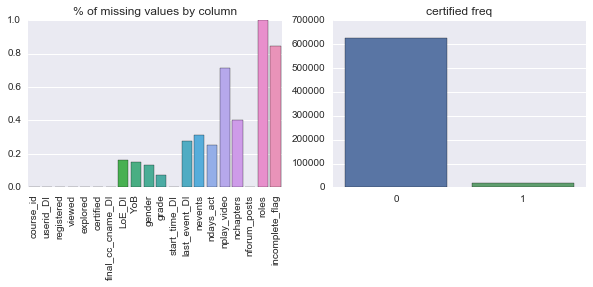

In [3]:
def quick_profile(df):
    f, ax = plt.subplots(1,2, figsize=(10,3))
    p = sns.barplot(y=np.sum(df.isnull(),axis=0)/df.shape[0], x= df.columns, ax = ax[0])
    p.set_xticklabels(df.columns, rotation=90);
    p.set_title('% of missing values by column');
    sns.barplot(y=np.bincount(df['certified']), x=[0,1], ax = ax[1]);
    ax[1].set_title('certified freq');

quick_profile(df)

**Ohoh, Less than 3% negative cases!** This means, we need to boost negative cases if possible.

** Now, I am not interested to classify those that does nothing beyond registration. ** By definition, that's `nevents` is not `null`.

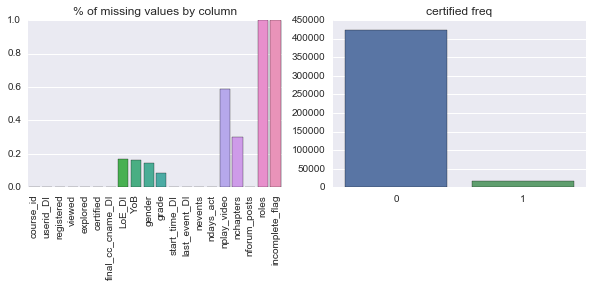

In [4]:
df = df[~df.nevents.isnull()]
quick_profile(df)

##### Now, let's profile
**Discrete Variables**

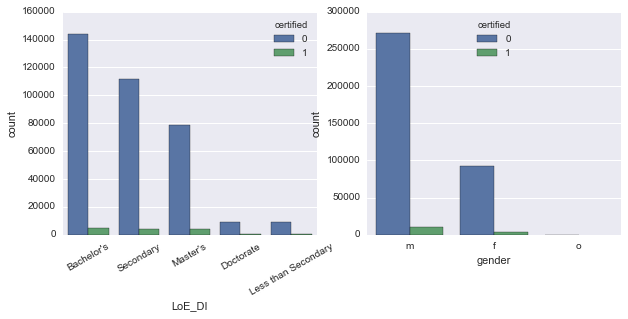

In [5]:
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.countplot(data=df[['LoE_DI', 'certified']], x = 'LoE_DI', hue = 'certified', ax = ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30);
sns.countplot(data=df[['gender', 'certified']], x = 'gender', hue = 'certified', ax = ax[1]);

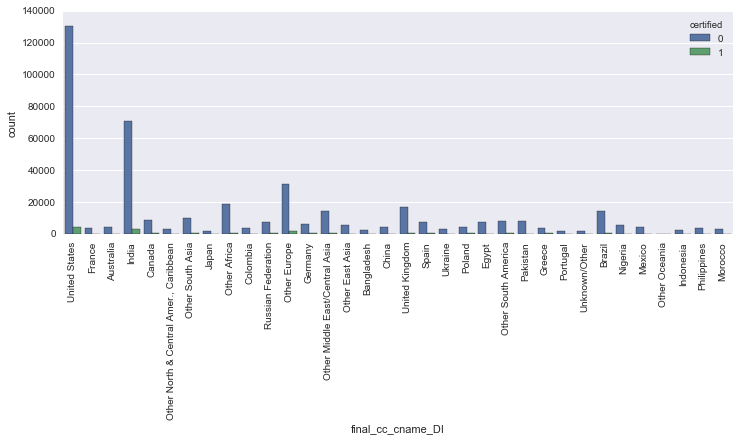

In [6]:
plt.figure(figsize=(12,4))
p = sns.countplot(data=df[['final_cc_cname_DI', 'certified']], x = 'final_cc_cname_DI', hue = 'certified')
p.set_xticklabels(p.get_xticklabels(), rotation=90);

**Numeric Variables**

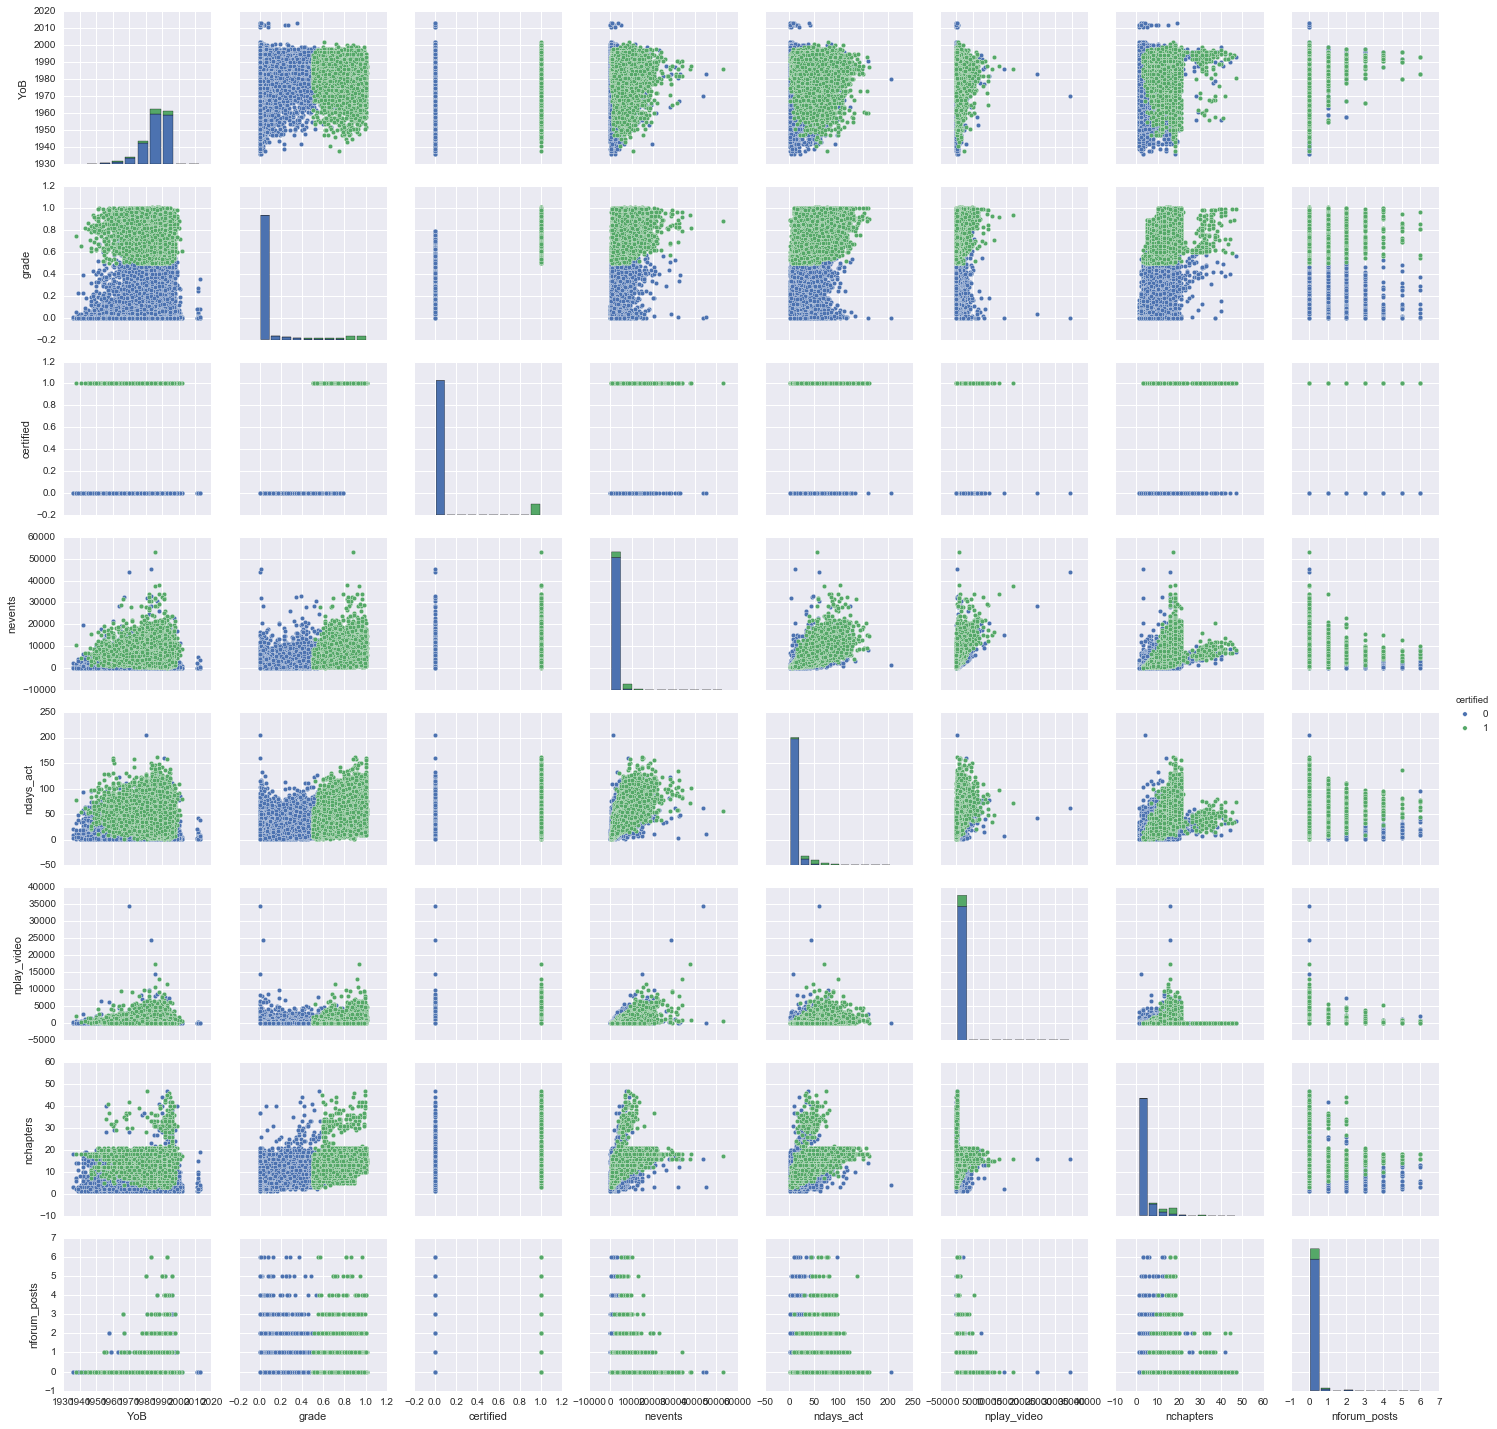

In [7]:
df.grade.replace('nan', np.nan, inplace=True)
df.grade.replace(' ', np.nan, inplace=True)
df.grade = df.grade.astype('float64')

sns.pairplot(
    data=df[['YoB', 'grade', 'certified', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts']].dropna(),
    hue="certified")

**As what we've seen, some data processing needs to take place**

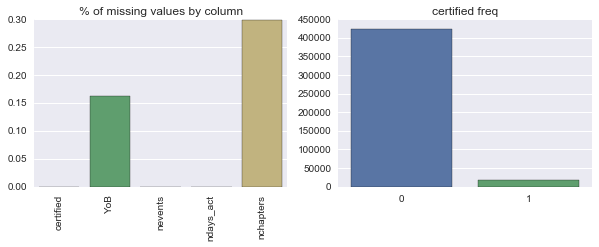

In [8]:
# drop `nplay_videio` since 60% of rows are missing
num = df[['certified', 'YoB', 'nevents', 'ndays_act', 'nchapters']]
quick_profile(num)

In [9]:
# dummy code nominal variables
def dict_lookup(df,f):
    unique = df[f].unique()
    lookup = {}
    i = 0
    for x in unique:
        lookup[x] = i
        i += 1
    
    return df[f].apply(lambda x: lookup[x]), lookup

lookups = {}
for x in ['final_cc_cname_DI', 'LoE_DI', 'gender']:
    v, lookups[x] = dict_lookup(df, x)
    df['%s_coded'%x] = v

In [11]:
data = df[['course_id', 'userid_DI', 'certified', 'YoB', 'nevents', 'ndays_act', 'nchapters', 'final_cc_cname_DI_coded', 'LoE_DI_coded', 'gender_coded']]

# from the profiling, you might notice some poeple are born in the future ???
# clean those out
data.loc[data['YoB'] >= 2013, 'YoB'] = 2013

# use most freq value to replace missing value
for x in ['YoB', 'nevents', 'ndays_act', 'nchapters']:
    replace_val = (np.bincount(data[x].dropna().astype('int64')).argmax())
    data.loc[data[x].isnull(), x] = replace_val

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
disc = enc.fit_transform(data[['final_cc_cname_DI_coded', 'LoE_DI_coded', 'gender_coded']])

# stack onehotcoded + numeric values
num = data.drop(['final_cc_cname_DI_coded', 'LoE_DI_coded', 'gender_coded'], axis=1)
d3 = np.hstack([num.values, disc])

In [13]:
# generate headers so we don't lost track of the data transformation afterwards
new = True

for x in ['final_cc_cname_DI', 'LoE_DI', 'gender']:
    t = []
    for y in lookups[x].keys():
        t.append([x, y,lookups[x][y]])
    t2 = pd.DataFrame(t).sort_values(2)
    if new:
        headers = t2.copy()
        new = False
    else:
        headers = pd.concat([headers, t2], axis = 0)

header = ['course_id', 'userid_DI', 'certified', 'YoB', 'nevents', 'ndays_act', 'nchapters']
header.extend(headers[1].values.tolist())
header

['course_id',
 'userid_DI',
 'certified',
 'YoB',
 'nevents',
 'ndays_act',
 'nchapters',
 'United States',
 'France',
 'Australia',
 'India',
 'Canada',
 'Other North & Central Amer., Caribbean',
 'Other South Asia',
 'Japan',
 'Other Africa',
 'Colombia',
 'Russian Federation',
 'Other Europe',
 'Germany',
 'Other Middle East/Central Asia',
 'Other East Asia',
 'Bangladesh',
 'China',
 'United Kingdom',
 'Spain',
 'Ukraine',
 'Poland',
 'Egypt',
 'Other South America',
 'Pakistan',
 'Greece',
 'Portugal',
 'Unknown/Other',
 'Brazil',
 'Nigeria',
 'Mexico',
 'Other Oceania',
 'Indonesia',
 'Philippines',
 'Morocco',
 nan,
 "Bachelor's",
 'Secondary',
 "Master's",
 'Doctorate',
 'Less than Secondary',
 nan,
 'm',
 'f',
 'o']

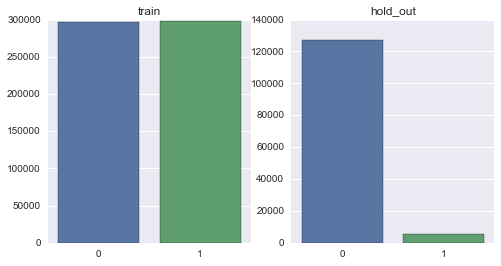

In [14]:
# best practive: create a hold out set
from sklearn.cross_validation import train_test_split
train, hold_out = train_test_split(d3, test_size=.3, random_state=0)

# balance the classification class in training set
# Repeated sample positive cases 24 times!
n = train[train[:,2] != 1]
y = train[train[:,2] == 1]
y2 = np.vstack([y for i in range(24)])
d4 = np.vstack([y2, n])

# take a look what I did
f, ax = plt.subplots(1,2, figsize=(8,4))
sns.barplot(y=np.bincount(d4[:,2].astype('int')), x = [0,1], ax = ax[0]);
ax[0].set_title('train');
sns.barplot(y = np.bincount(hold_out[:,2].astype('int')), x = [0,1], ax = ax[1]);
ax[1].set_title('hold_out');

##### Train the classification model

Now that we've seen enough, let's try to train the model.

In [15]:
# create train/test within training set
train_tr, train_x = train_test_split(train, test_size=.3, random_state=0)

**Decision Tree**

In [52]:
# first, let's try a decision tree
from sklearn.tree import DecisionTreeClassifier

# let's draw a training curve and see if this works
clss = dict()
test_err = []
train_err = []

for x in tqdm(range(5,50,5)):
    clss[x] = DecisionTreeClassifier(max_depth=x)
    clss[x].fit(train_tr[:,3:], train_tr[:,2].astype('int64'))
    test_err.append(1-clss[x].score(train_x[:, 3:], train_x[:, 2].astype('int')))
    train_err.append(1-clss[x].score(train_tr[:,3:], train_tr[:,2].astype('int')))

100%|████████████████████████████████████████████| 9/9 [00:04<00:00,  1.97it/s]


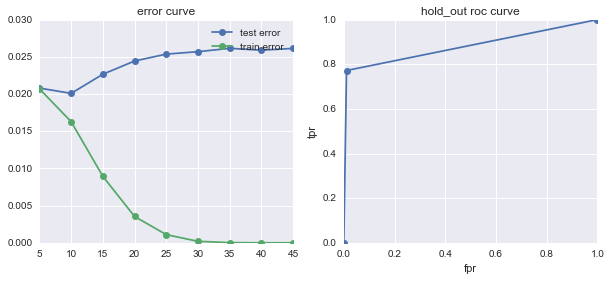

In [53]:
def training_curve(test, train, param, ax):
    ax.plot(param, test_err, '-o');
    ax.plot(param, train_err, '-o');
    ax.legend(['test error', 'train error']);
    ax.set_title('error curve');

def roc(model, true, data, ax):
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(true, model.predict(data));
    ax.plot(fpr, tpr, '-o');
    ax.set_xlabel('fpr');
    ax.set_ylabel('tpr');
    ax.set_title('hold_out roc curve');
    
f, ax = plt.subplots(1,2, figsize=(10,4))
training_curve(test_err, train_err, range(5,50,5), ax[0])
roc(clss[10], hold_out[:,2], hold_out[:,3:], ax[1])

**Random Forest**

In [54]:
# it does an okay job on hold_out, so let's see how to improvee this even more!
# unfortunately, there's no existing prune module in sklearn
# let's try DT's ensemble version -> RF

from sklearn.ensemble import RandomForestClassifier

# clss2 = dict()
test_err = []
train_err = []

for x in tqdm(range(5,50,5)):
    clss2[x] = RandomForestClassifier(max_depth=x)
    clss2[x].fit(train_tr[:,3:], train_tr[:,2].astype('int64'))
    test_err.append(1-clss2[x].score(train_x[:, 3:], train_x[:, 2].astype('int')))
    train_err.append(1-clss2[x].score(train_tr[:,3:], train_tr[:,2].astype('int')))

100%|████████████████████████████████████████████| 9/9 [00:07<00:00,  1.19it/s]


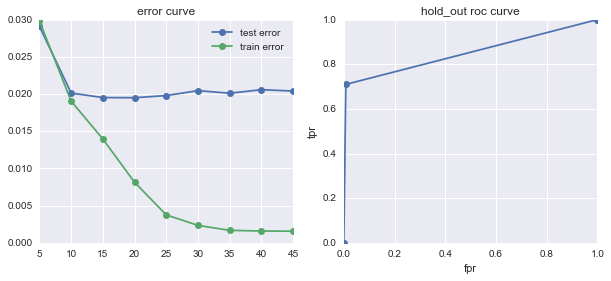

In [55]:
f, ax = plt.subplots(1,2, figsize=(10,4))
training_curve(test_err, train_err, range(5,50,5), ax[0])
roc(clss2[15], hold_out[:,2], hold_out[:,3:], ax[1])

**SVM**

In [45]:
# alright, not really helping
# let's try SVM

from sklearn.svm import LinearSVC

clss3 = dict()
test_err = []
train_err = []

for c in tqdm(range(80,120,5)):
    clss3[c] = LinearSVC(C=(c*.01))
    clss3[c].fit(train_tr[:,3:], train_tr[:,2].astype('int64'))
    test_err.append(1-clss3[c].score(train_x[:, 3:], train_x[:, 2].astype('int')))
    train_err.append(1-clss3[c].score(train_tr[:,3:], train_tr[:,2].astype('int')))

100%|████████████████████████████████████████████| 8/8 [06:40<00:00, 49.96s/it]


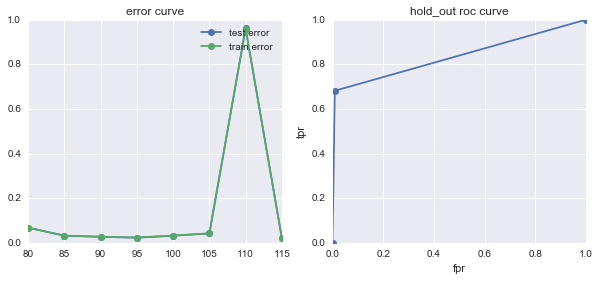

In [51]:
f, ax = plt.subplots(1,2, figsize=(10,4))
training_curve(test_err, train_err, range(80,120,5), ax[0])
roc(clss3[115], hold_out[:,2], hold_out[:,3:], ax[1])